# Imports and Device Setup

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score  # For evaluation metrics

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# Data Loading and Preprocessing

In [2]:
# ------------------------------------------
# Data Loader (Adjust the path)
# ------------------------------------------
data_dir = '/kaggle/input/recyclable-and-household-waste-classification/images/images'  # Change this path as needed

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset and split into training and validation sets
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

print("Number of classes:", num_classes)


Number of classes: 30


# Optional - Batch Plotting Function

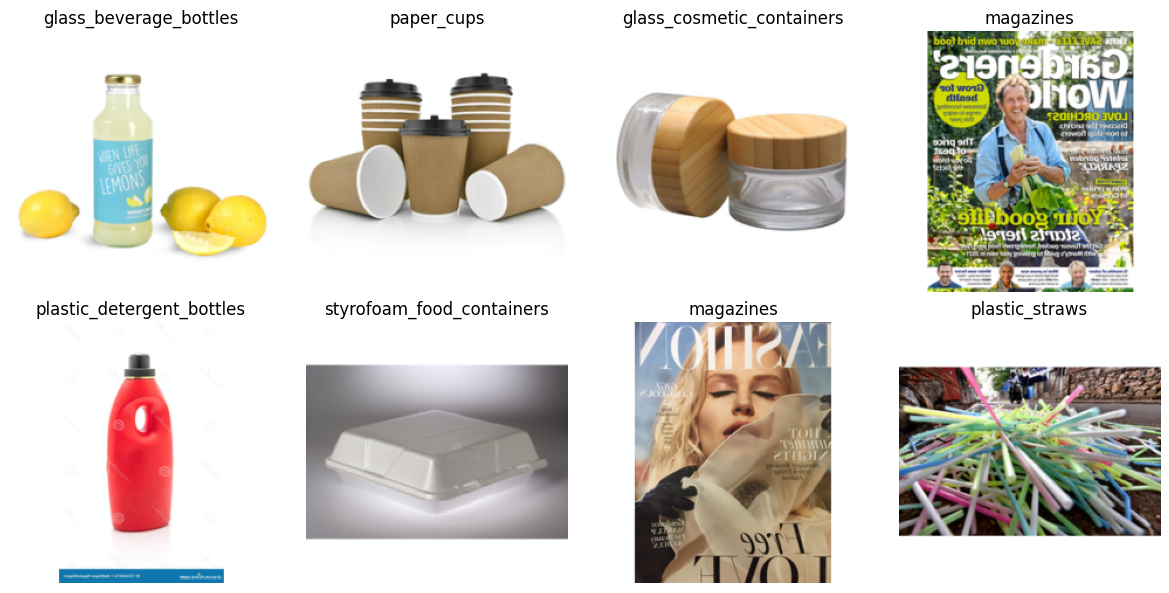

In [3]:
# ------------------------------------------
# Plot function for batches (optional)
# ------------------------------------------
def plot_batch(loader, classes):
    images, labels = next(iter(loader))
    plt.figure(figsize=(12,6))
    for i in range(min(8, len(images))):
        # Undo normalization for display purposes
        img = images[i].permute(1,2,0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        plt.subplot(2,4,i+1)
        plt.imshow(img.clip(0,1))
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example batch plotting
plot_batch(val_loader, dataset.classes)


# Define Base Models

In [4]:
# ------------------------------------------
# Define Base Models
# ------------------------------------------
def get_model(model_name, num_classes):
    model = getattr(models, model_name)(pretrained=True)
    if 'resnet' in model_name:
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif 'efficientnet' in model_name or 'mobilenet' in model_name:
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif 'densenet' in model_name:
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

# List of model names to use
model_names = ['resnet50', 'efficientnet_b0', 'mobilenet_v2', 'densenet121']
models_list = [get_model(name, num_classes) for name in model_names]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

# Train Base Models with Early Stopping

In [5]:
# ------------------------------------------
# Train Base Models with Early Stopping
# ------------------------------------------
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, max_epochs=30, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    for epoch in range(max_epochs):
        model.train()
        total_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
        train_loss = total_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        val_loss /= len(val_loader.dataset)
        
        print(f"{model.__class__.__name__} Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict()  # Save best model state
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered for {model.__class__.__name__} after {epoch+1} epochs")
                if best_state is not None:
                    model.load_state_dict(best_state)  # Restore best state
                break

# Train each base model
for model in models_list:
    train_model(model, train_loader, val_loader, max_epochs=30, patience=5)

ResNet Epoch 1/30 | Train Loss: 0.9468, Train Acc: 0.7287 | Val Loss: 0.5388
ResNet Epoch 2/30 | Train Loss: 0.4060, Train Acc: 0.8647 | Val Loss: 0.4490
ResNet Epoch 3/30 | Train Loss: 0.2753, Train Acc: 0.9032 | Val Loss: 0.5060
ResNet Epoch 4/30 | Train Loss: 0.2167, Train Acc: 0.9233 | Val Loss: 0.4572
ResNet Epoch 5/30 | Train Loss: 0.1884, Train Acc: 0.9308 | Val Loss: 0.4885
ResNet Epoch 6/30 | Train Loss: 0.1616, Train Acc: 0.9413 | Val Loss: 0.4747
ResNet Epoch 7/30 | Train Loss: 0.1526, Train Acc: 0.9440 | Val Loss: 0.5015
Early stopping triggered for ResNet after 7 epochs
EfficientNet Epoch 1/30 | Train Loss: 1.7099, Train Acc: 0.5788 | Val Loss: 0.6996
EfficientNet Epoch 2/30 | Train Loss: 0.6187, Train Acc: 0.8073 | Val Loss: 0.4580
EfficientNet Epoch 3/30 | Train Loss: 0.4044, Train Acc: 0.8729 | Val Loss: 0.3901
EfficientNet Epoch 4/30 | Train Loss: 0.2979, Train Acc: 0.9005 | Val Loss: 0.3585
EfficientNet Epoch 5/30 | Train Loss: 0.2284, Train Acc: 0.9200 | Val Loss: 0.

# Weighted Ensemble and Training Ensemble Weights

In [6]:
# ------------------------------------------
# Weighted Ensemble and Training with Early Stopping
# ------------------------------------------
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
        self.weights = nn.Parameter(torch.ones(len(models)))

    def forward(self, x):
        outputs = torch.stack([model(x) for model in self.models])
        weights = torch.softmax(self.weights, dim=0).view(-1, 1, 1)
        return torch.sum(outputs * weights, dim=0)

ensemble_model = EnsembleModel(models_list).to(device)

def train_ensemble_weights(ensemble, loader, max_epochs=10, patience=2):
    optimizer = optim.Adam([ensemble.weights], lr=1e-3)
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    for epoch in range(max_epochs):
        ensemble.train()
        total_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = ensemble(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
        train_loss = total_loss / len(loader.dataset)
        
        # Since we use the same loader for validation here
        ensemble.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = ensemble(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        val_loss /= len(loader.dataset)
        
        print(f"Ensemble weights Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = ensemble.weights.detach().clone()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered for ensemble weights after {epoch+1} epochs")
                ensemble.weights.data.copy_(best_state)
                break

train_ensemble_weights(ensemble_model, val_loader, max_epochs=30, patience=5)


Ensemble weights Epoch 1/30 | Train Loss: 0.3520 | Val Loss: 0.3317
Ensemble weights Epoch 2/30 | Train Loss: 0.3502 | Val Loss: 0.3298
Ensemble weights Epoch 3/30 | Train Loss: 0.3509 | Val Loss: 0.3288
Ensemble weights Epoch 4/30 | Train Loss: 0.3525 | Val Loss: 0.3287
Ensemble weights Epoch 5/30 | Train Loss: 0.3452 | Val Loss: 0.3306
Ensemble weights Epoch 6/30 | Train Loss: 0.3472 | Val Loss: 0.3294
Ensemble weights Epoch 7/30 | Train Loss: 0.3514 | Val Loss: 0.3279
Ensemble weights Epoch 8/30 | Train Loss: 0.3497 | Val Loss: 0.3303
Ensemble weights Epoch 9/30 | Train Loss: 0.3480 | Val Loss: 0.3301
Ensemble weights Epoch 10/30 | Train Loss: 0.3520 | Val Loss: 0.3281
Ensemble weights Epoch 11/30 | Train Loss: 0.3525 | Val Loss: 0.3272
Ensemble weights Epoch 12/30 | Train Loss: 0.3495 | Val Loss: 0.3296
Ensemble weights Epoch 13/30 | Train Loss: 0.3540 | Val Loss: 0.3288
Ensemble weights Epoch 14/30 | Train Loss: 0.3500 | Val Loss: 0.3290
Ensemble weights Epoch 15/30 | Train Loss: 

# Evaluation of Models

In [7]:
# ------------------------------------------
# Evaluate Models with Precision, Recall and F1 Score
# ------------------------------------------
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Evaluate each base model
for model in models_list:
    true_labels, predictions = evaluate_model(model, val_loader)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    print(f"{model.__class__.__name__} -> Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Evaluate the ensemble model
true_labels, predictions = evaluate_model(ensemble_model, val_loader)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
print(f"EnsembleModel -> Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


ResNet -> Precision: 0.8638, Recall: 0.8610, F1 Score: 0.8596
EfficientNet -> Precision: 0.8807, Recall: 0.8803, F1 Score: 0.8790
MobileNetV2 -> Precision: 0.8722, Recall: 0.8720, F1 Score: 0.8714
DenseNet -> Precision: 0.8723, Recall: 0.8720, F1 Score: 0.8709
EnsembleModel -> Precision: 0.8954, Recall: 0.8950, F1 Score: 0.8942
